# Gradient verification for the 1D pure diffusion case

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import os
from pathlib import Path
import logging
import copy
import time
from typing import Dict, Generator, Iterable
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from pyrtid.utils import GaussianFilter
import nested_grid_plotter as ngp
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np

import pandas as pd
import scipy as sp
import gstools as gs
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)
from pyrtid.inverse.params import (
    eval_weighted_loss_reg,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path: str = os.path.dirname(os.path.realpath("__file__"))
fig_save_path: Path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
# Geometry
nx = 20  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 10.0  # voxel dimension along the x axis
dy = 10.0  # voxel dimension along the y axis

# Time parameters
duration_in_d = 20  # duration in days
duration_in_s = duration_in_d * 3600 * 24
dt_init = 3600 * 2  # timestep in seconds
dt_max = dt_init * 2
dt_min = dt_init / 2

# Others
c0 = 0  # general initial cocentration
D0 = 1e-4  # general initial diffusion coefficient
w0 = 0.23  # general porosity
crank_nicolson_diffusion = 0.9

- x_coordinates array for the plots

In [7]:
x_coordinates = (np.arange(nx) + 0.5) * dx

- Create an initial "bumped" reference distribution for the diffusion, and a flat one for the initial estimation.

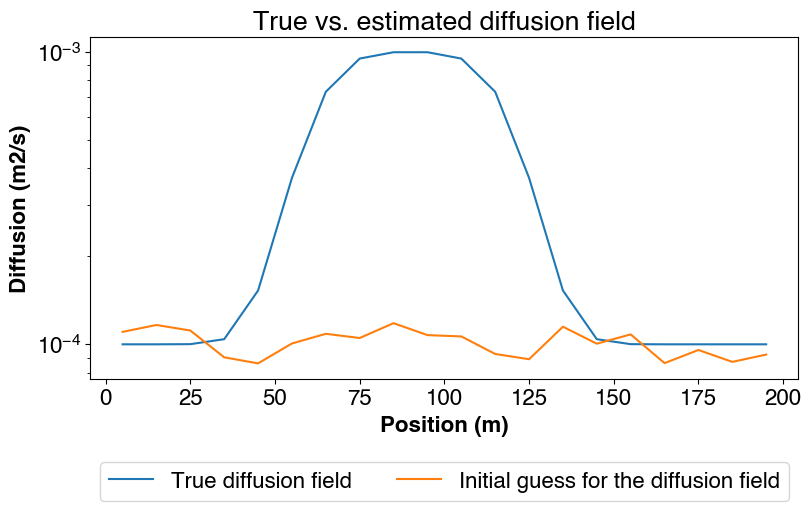

In [8]:
# Exact mineral distribution
diffusion_true: NDArrayFloat = np.ones(nx) * D0
diffusion_true[6:12] = 1e-3
diffusion_true = sp.ndimage.gaussian_filter(diffusion_true, sigma=1)

# Estimated diffusion
diffusion_estimated: NDArrayFloat = (
    np.ones(nx)
    * D0
    * (1 + np.random.default_rng(2024).normal(loc=0.0, scale=0.1, size=nx))
)

plotter = ngp.NestedGridPlotter(fig_params={"figsize": (8, 5)})
plotter.ax_dict["ax1-1"].plot(
    x_coordinates, diffusion_true, label="True diffusion field"
)
plotter.ax_dict["ax1-1"].plot(
    x_coordinates,
    diffusion_estimated,
    label="Initial guess for the diffusion field",
)
plotter.ax_dict["ax1-1"].set_xlabel("Position (m)", weight="bold")
plotter.ax_dict["ax1-1"].set_ylabel("Diffusion (m2/s)", weight="bold")
plotter.ax_dict["ax1-1"].set_yscale("log")
plotter.ax_dict["ax1-1"].legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plotter.ax_dict["ax1-1"].set_title("True vs. estimated diffusion field")
plotter.fig.set_facecolor("w")

fname = "true_vs_estimated_diffusion_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Note: The initial concentration is the same in both cases and has a blocky shape.

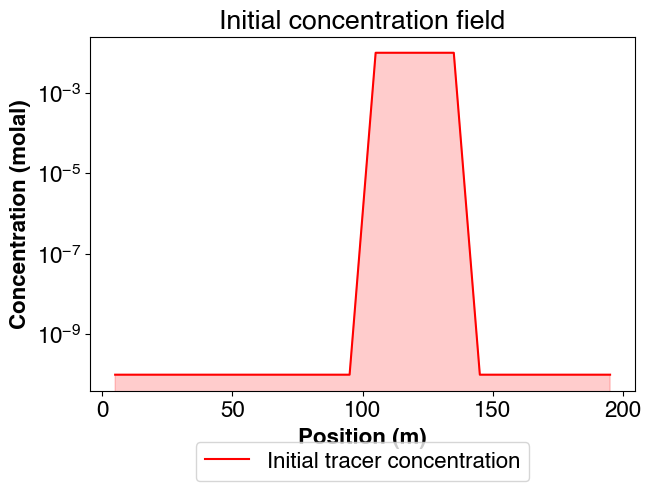

In [9]:
zone_high_conc_start = 10
zone_high_conc_stop = 14

c_min = 1e-10  # [mol/kg]
c_max = 1e-2  # [mol/kg]
c_init = np.ones((nx)) * c_min
c_init[zone_high_conc_start:zone_high_conc_stop] = c_max

plotter = ngp.NestedGridPlotter()
plotter.ax_dict["ax1-1"].plot(
    x_coordinates,
    c_init,
    label="Initial tracer concentration",
    color="red",
)
plotter.ax_dict["ax1-1"].fill_between(
    x_coordinates,
    0.0,
    c_init,
    alpha=0.2,
    color="red",
)
plotter.ax_dict["ax1-1"].set_xlabel("Position (m)", weight="bold")
plotter.ax_dict["ax1-1"].set_ylabel("Concentration (molal)", weight="bold")
plotter.ax_dict["ax1-1"].set_yscale("log")
plotter.ax_dict["ax1-1"].legend(loc="center", bbox_to_anchor=(0.5, -0.2), ncol=2)
plotter.ax_dict["ax1-1"].set_title("Initial concentration field")
plotter.fig.set_facecolor("w")

fname = "initial_tracer_concentration"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Forward problem in demonstrator

In [10]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dx)
fl_params = dmfwd.FlowParameters()
tr_params = dmfwd.TransportParameters(
    diffusion=D0, porosity=w0, crank_nicolson_diffusion=crank_nicolson_diffusion
)
gch_params = dmfwd.GeochemicalParameters(conc=c0, grade=0.0)


# We define a function to easily generate a model.
def create_base_model() -> dmfwd.ForwardModel:
    return dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Create two models

In [11]:
diffusion_true.shape

(20,)

In [12]:
model_reference = create_base_model()
model_estimate = create_base_model()
# Exact diffusion
model_reference.tr_model.diffusion[:, 0] = diffusion_true
# Estimated diffusion
model_estimate.tr_model.diffusion[:, 0] = diffusion_estimated

model_reference.tr_model.set_initial_conc(c_init.reshape(-1, 1))
model_estimate.tr_model.set_initial_conc(c_init.reshape(-1, 1))

- Run the models

In [13]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

- Some fun plots, not very informative though...

Text(0.5, 0.98, 'Estimate demonstrator')

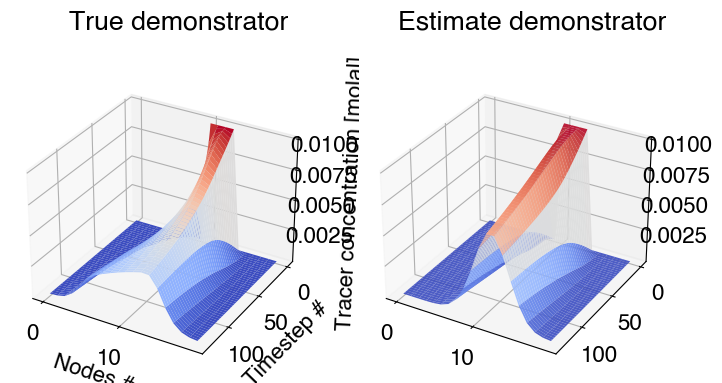

In [14]:
# Let's create a 3D plotter to visualize the results
plotter_3d = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (7, 4)},
    subfigs_params={"ncols": 2},
    subplots_mosaic_params={
        "reference demonstrator": {
            "mosaic": [["ax1-1"]],
            "subplot_kw": {"projection": "3d"},
        },
        "estimate demonstrator": {
            "mosaic": [["ax1-2"]],
            "subplot_kw": {"projection": "3d"},
        },
    },
)
plotter_3d.fig.patch.set_facecolor("w")

data: NDArrayFloat = model_reference.tr_model.conc[:, 0, :]
X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
ax = plotter_3d.ax_dict["ax1-1"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["reference demonstrator"].suptitle("True demonstrator")
ax.set_xlabel("Nodes #")
ax.set_ylabel("Timestep #")
ax.set_zlabel("Tracer concentration [molal]")

data: NDArrayFloat = model_estimate.tr_model.conc[:, 0, :]
ax = plotter_3d.ax_dict["ax1-2"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm, alpha=0.9)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["estimate demonstrator"].suptitle("Estimate demonstrator")

- Top view

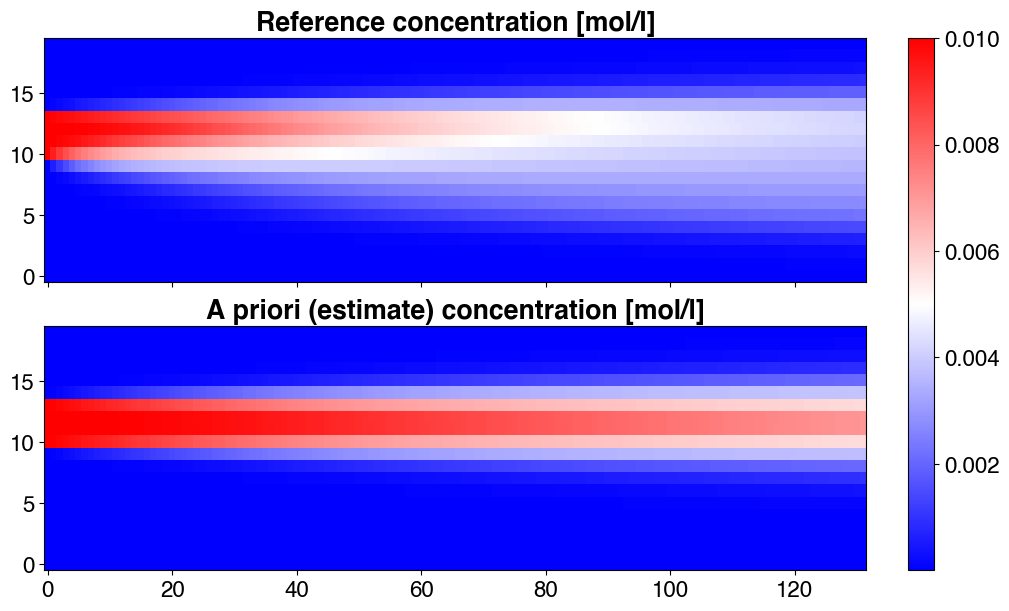

In [15]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference concentration [mol/l]": model_reference.tr_model.conc[:, 0, :].T,
        "A priori (estimate) concentration [mol/l]": model_estimate.tr_model.conc[
            :, 0, :
        ].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- We will also use some density points as observations: it should be more or less the same because the two are proportionnal

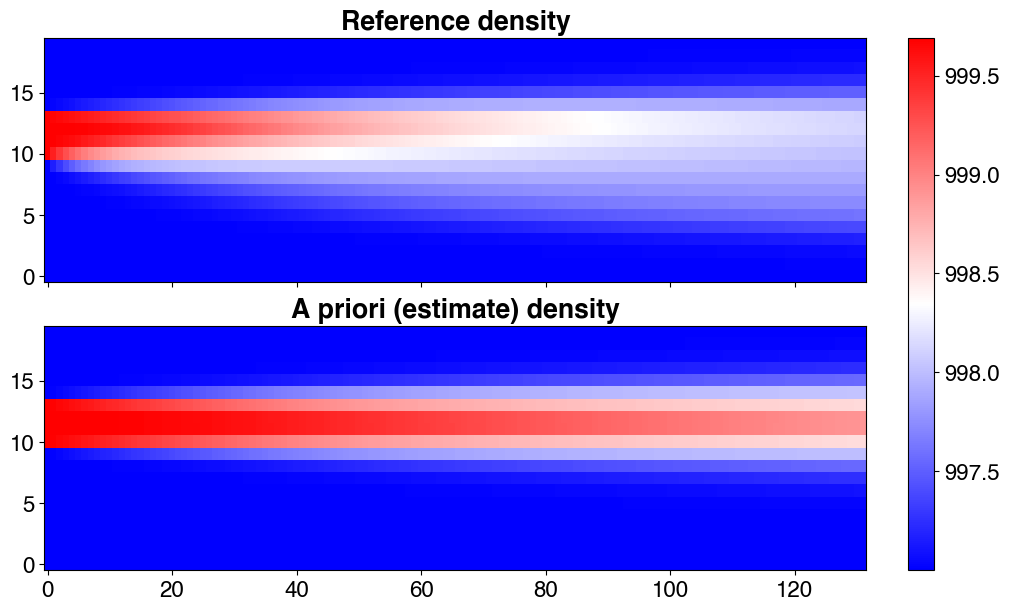

In [16]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference density": model_reference.tr_model.density[:, 0, :].T,
        "A priori (estimate) density": model_estimate.tr_model.density[:, 0, :].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Consider three observation locations

In [17]:
observation_locations = [6, 10, 15]

- Let's now consider that we have some observation wells. We can plot what the observation well would sample in both cases and see the difference. Let's place three wells at positions `65m`, `105m` and `155m` (at the center of the nodes).

In [18]:
model_reference.tr_model.conc.shape

(20, 1, 132)

In [19]:
from typing import List, Tuple


def polygon_under_graph(x: np.ndarray, y: np.ndarray) -> List[Tuple[float, float]]:
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.0), *zip(x, y), (x[-1], 0.0)]


y_dim = model_reference.tr_model.conc.shape[2]
z_max = model_reference.tr_model.conc.max()
y = np.arange(y_dim)
z = np.ones(y_dim) * z_max

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(y, z)] * len(observation_locations)

poly1 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly2 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)

plotter_3d.ax_dict["ax1-1"].add_collection3d(poly1, zs=observation_locations, zdir="x")
plotter_3d.ax_dict["ax1-2"].add_collection3d(poly2, zs=observation_locations, zdir="x")

for node_id in observation_locations:
    x = [node_id] * 2
    y = [model_reference.tr_model.conc.shape[2]] * 2
    z = (0.0, z_max)

    plotter_3d.ax_dict["ax1-1"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax1-2"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
fname = "tracer_concentration_true_vs_estimate_3D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

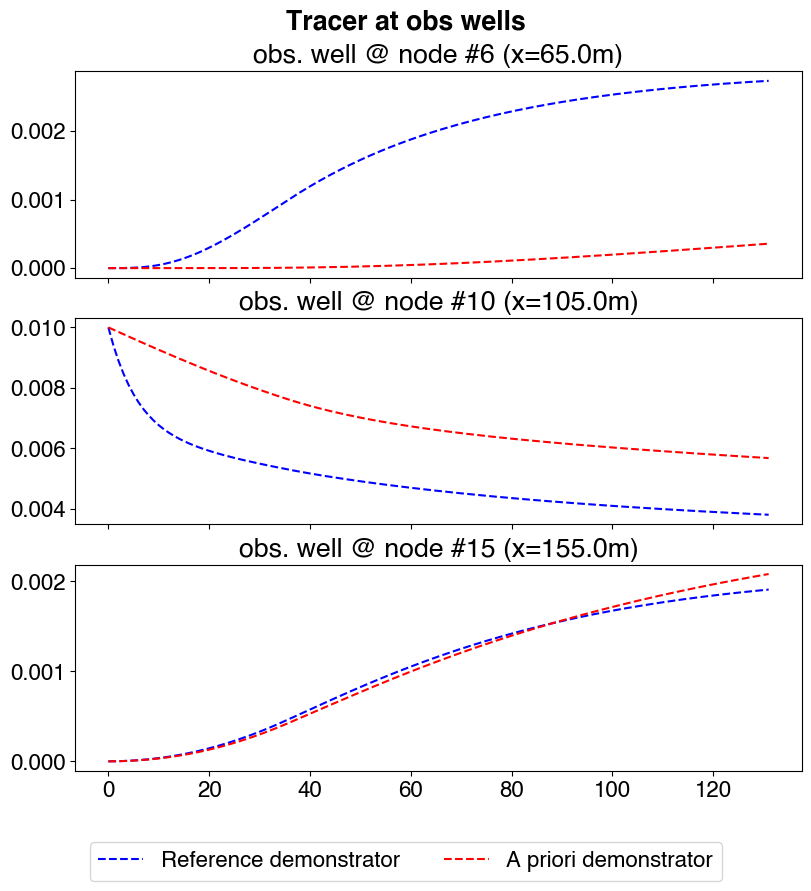

In [20]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.tr_model.conc[node_id, 0, :],
        label="Reference demonstrator",
        c="b",
        linestyle="--",
        zorder=2,
    )
    ax.plot(
        model_estimate.tr_model.conc[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
        linestyle="--",
        zorder=2,
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [21]:
# function for time display
# plot the time
def get_time(nb_frames: int) -> Generator[str, None, None]:
    ts_btw_frames = model_reference.time_params.nt / nb_frames
    for frame in range(nb_frames):
        yield f"time = {model_reference.time_params.times[int(ts_btw_frames * frame)] / 3600:.3f} h"

In [22]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

# Static plot
for ax_name in ["ax1-1"]:
    plotter.get_axis(ax_name).plot(
        model_reference.tr_model.conc[:, 0, 0], c="red", label="Initial"
    )

# Animated plot
nb_frames = min(12, model_reference.time_params.nt)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "y": model_reference.tr_model.conc[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.conc[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Demonstrator conc",
    xlabel="Node #",
)

for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        # handle = plotter.ax_dict["ax1-1"].axvline(
        #     x=well_pos, linestyle="--", line
        # )
        # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
        plotter.get_axis(ax_name).plot(
            well_pos,
            0.0002,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time(nb_frames)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

- Create a function to add some noise to the observations

In [23]:
freq_measure_in_d = 2  # one measure every two days
n_sampled_days = duration_in_d / freq_measure_in_d

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d
obs_times_in_s

array([      0.,  172800.,  345600.,  518400.,  691200.,  864000.,
       1036800., 1209600., 1382400., 1555200.])

In [24]:
duration_in_d

20

In [25]:
duration_in_s

1728000

In [26]:
time_params.time_elapsed

1742359.4437376535

In [27]:
noise_std_conc: float = 1e-4  # This is an absolute value
noise_std_density: float = 0.05  # This is an absolute value


def get_white_noise(shape: Iterable[int], noise_std: float) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise_conc: NDArrayFloat = get_white_noise(
    (len(observation_locations), obs_times_in_s.size), noise_std_conc
)
obs_noise_density: NDArrayFloat = get_white_noise(
    (len(observation_locations), obs_times_in_s.size), noise_std_density
)

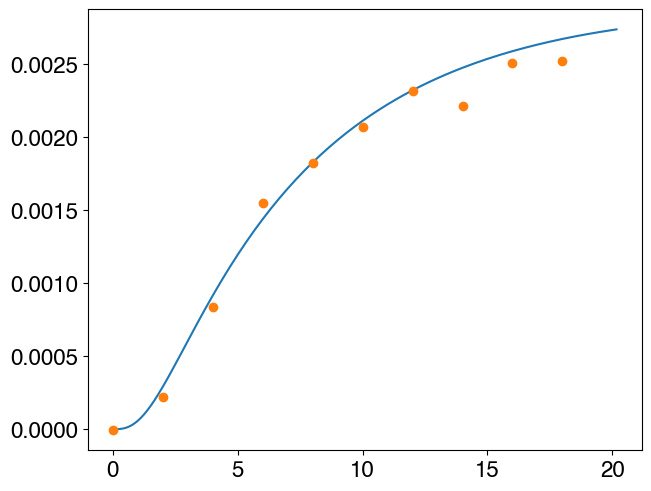

In [28]:
all_times = model_estimate.time_params.times

obs_values_conc = np.zeros((len(observation_locations), obs_times_in_s.size))

for count, ix in enumerate(observation_locations):
    # interpolate the values
    obs_values_conc[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.tr_model.conc[ix, 0, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise_conc[count, :]
    )

count = 0

ix = observation_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.tr_model.conc[ix, 0, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values_conc[count],
    marker="o",
    linestyle="none",
)

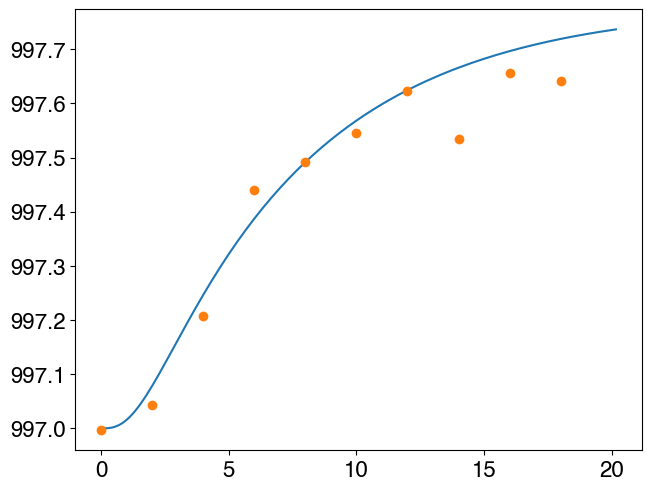

In [29]:
obs_values_density = np.zeros((len(observation_locations), obs_times_in_s.size))

for count, ix in enumerate(observation_locations):
    # interpolate the values
    obs_values_density[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.tr_model.density[ix, 0, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise_density[count, :]
    )

count = 0

ix = observation_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.tr_model.density[ix, 0, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values_density[count],
    marker="o",
    linestyle="none",
)

### Demonstrator


In [45]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.DIFFUSION,
    lbounds=2e-5,
    ubounds=5e-3,
    preconditioner=dminv.LogTransform(),
    regularizators=dminv.regularization.TikhonovRegularizator(
        dx, dy, preconditioner=dminv.LogTransform()
    ),
    reg_weight_update_strategy=dminv.regularization.RegWeightUpdateStrategy.ADAPTIVE_UC,
)

observables = []
for i, node_id in enumerate(observation_locations):
    # Ovservations on concentrations
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.CONCENTRATION,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values_conc[i],
            uncertainties=noise_std_conc,
            sp=0,
        )
    )

    # Observations on density
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.DENSITY,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values_density[i],
            uncertainties=noise_std_density,
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.LBFGSBSolverConfig(
    maxfun=20, maxiter=20, ftol=1e-4, gtol=1e-4, maxls=3, is_use_adjoint=True
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.LBFGSBInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(param.preconditioner(param.values), is_save_state=False)
is_grad_ok = executor.is_adjoint_gradient_correct(max_workers=4)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 4528.374703928162
INFO:root:Loss (obs fit) / Nobs = 75.47291173213603
INFO:root:Loss (regularization) = 0.001444081672644963
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 1.0



[-5.40864055e-04  9.82719983e-04  2.06293929e-03  2.15139040e-02
  9.95423776e-01  2.14318608e+01 -5.66887880e+01 -1.77834400e+02
 -3.82035126e+02 -2.11797141e+03 -1.25115718e+03  6.46175476e+02
 -6.00917061e+01 -9.24154176e+01 -4.89063672e+01 -2.47115128e-01
 -5.42317298e+00 -6.47749969e-01 -4.34951462e-02 -6.14861138e-04]
[-5.41225136e-04  9.81820095e-04  2.06396998e-03  2.15141310e-02
  9.95431753e-01  2.14318580e+01 -5.66887826e+01 -1.77834389e+02
 -3.82035123e+02 -2.11797140e+03 -1.25115717e+03  6.46175470e+02
 -6.00917049e+01 -9.24154160e+01 -4.89063812e+01 -2.47107086e-01
 -5.42317086e+00 -6.47750964e-01 -4.34941646e-02 -6.14369757e-04]


In [46]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


In [47]:
param.grad_adj_raw_history[-1].shape

(20, 1)

In [48]:
executor.adj_model.a_tr_model.a_conc.shape

(2, 20, 1, 132)

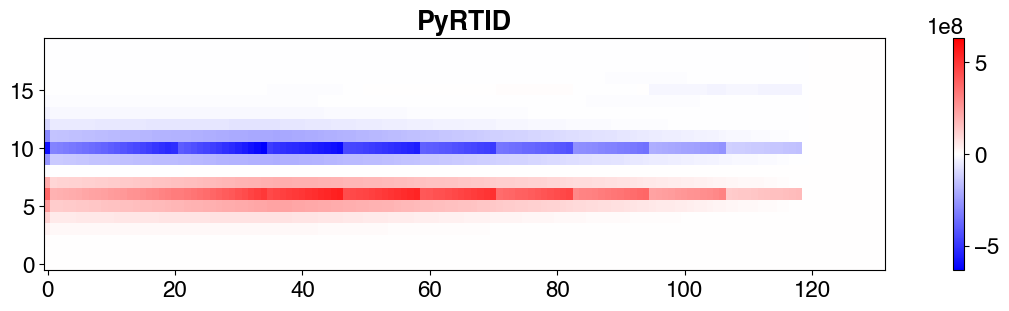

In [49]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 3)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "PyRTID": executor.adj_model.a_tr_model.a_conc[0, :, 0, :].T,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

Let's check the adjoint variables at the three observation wells. Note that only the right one has been used as an adjoint source (node_id == 15).

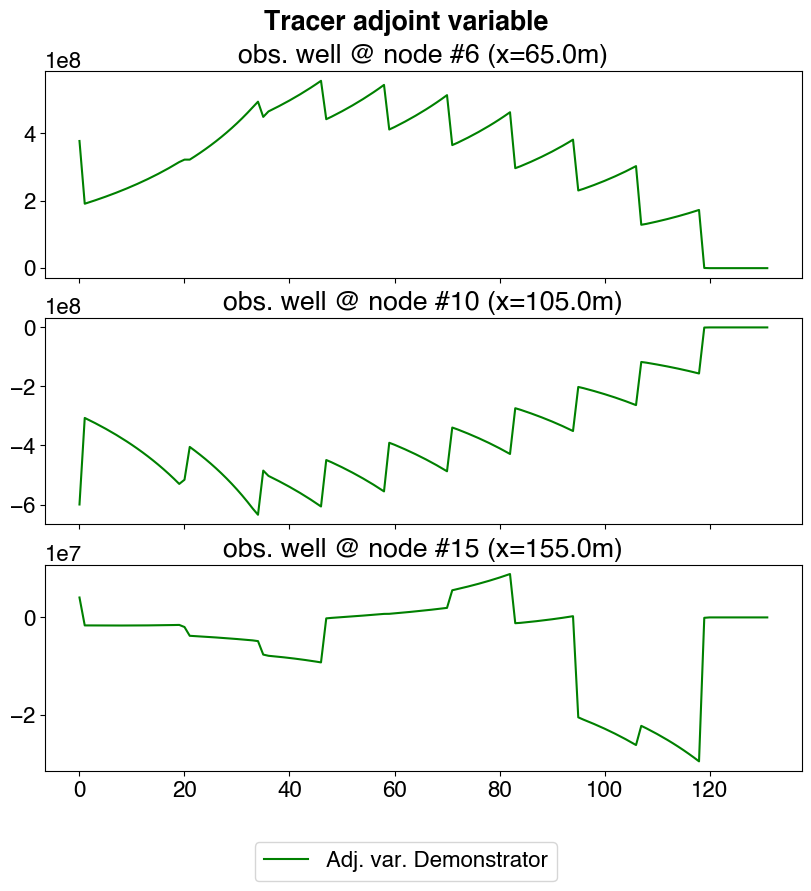

In [50]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        executor.adj_model.a_tr_model.a_conc[0, node_id, 0, :],
        label="Adj. var. Demonstrator",
        c="g",
    )

plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "adjoint_concentrations_dem_vs_hytec_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

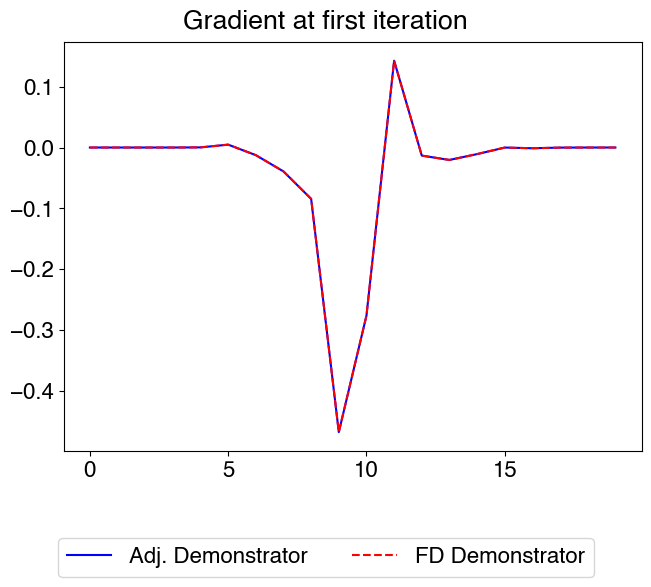

In [51]:
# Here comes the python code
scaling_factor = executor.inv_model.scaling_factor

plotter = ngp.NestedGridPlotter()
ax = plotter.get_axis("ax1-1")

ax.plot(
    param.grad_adj_history[0] * scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)

plotter.fig.suptitle("Gradient at first iteration")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [52]:
from pyrtid.utils import is_all_close

is_all_close(param.grad_adj_history[0], param.grad_fd_history[0].ravel())

True

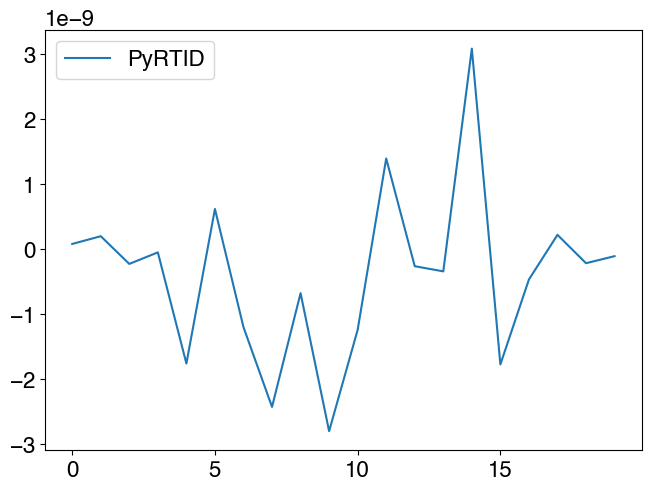

In [53]:
plt.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0].ravel()) * scaling_factor,
    label="PyRTID",
)
plt.legend()

# Full optimization

In [54]:
executor.run()

INFO:root:============================= Inversion Parameters =============================
INFO:root:Method                                            : L-BFGS-B (PyRTID)
INFO:root:
INFO:root:Number of adjusted parameters                     : 1
INFO:root:Number of unknowns (adjusted values)              : 20
INFO:root:Number of observables                             : 6
INFO:root:Number of observation data points (values)        : 60
INFO:root:================================================================================
INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 4528.374703928162
INFO:root:Loss (obs fit) / Nobs = 75.47291173213603
INFO:root:Loss (regularization) = 0.001444081672644963
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 1.0

INFO:root:- Running gradient # 1
INFO:root:- Gradient eval # 1 over

INFO:root:- Running forward model # 2
INFO:root:- Run # 2 over
INFO:root:Loss (obs fit)        = 3229.8377575495297
INFO:root:Loss (obs fit) / Nobs = 53.83062929249216
INFO:root:Loss (regularization) = 0.0036206572008529426
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.7132449409323486

INFO:root:- Running gradient # 2
INFO:root:- Gradient eval # 2 over

INFO:root:- Updating regularization weights # 1
INFO:root:Old reg weight (diffusion)   = 1.0
INFO:root:New reg weight (diffusion)   = 37758.53618450619
INFO:root:New loss regularization   = 136.71071593009873
INFO:root:New loss (scaled)         = 0.

case3


INFO:root:- Run # 3 over
INFO:root:Loss (obs fit)        = 1226.7402651168968
INFO:root:Loss (obs fit) / Nobs = 20.445671085281614
INFO:root:Loss (regularization) = 799.2667448287639
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.4474025442511143

INFO:root:- Running gradient # 3
INFO:root:- Gradient eval # 3 over

INFO:root:- Updating regularization weights # 2
INFO:root:Old reg weight (diffusion)   = 37758.53618450619
INFO:root:New reg weight (diffusion)   = 7562.778837238416
INFO:root:New loss regularization   = 160.08771085728108
INFO:root:New loss (scaled)         = 0.3062528223464103

INFO:root:- Updating regularization weights # 2 over
INFO:root:- Running forward model # 4


case3


INFO:root:- Run # 4 over
INFO:root:Loss (obs fit)        = 712.5008177174813
INFO:root:Loss (obs fit) / Nobs = 11.875013628624687
INFO:root:Loss (regularization) = 202.63731697755637
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.20208969060514761

INFO:root:- Running gradient # 4
INFO:root:- Gradient eval # 4 over

INFO:root:- Updating regularization weights # 3
INFO:root:Old reg weight (diffusion)   = 7562.778837238416
INFO:root:New reg weight (diffusion)   = 8042.247915523633
INFO:root:New loss regularization   = 215.4842254603246
INFO:root:New loss (scaled)         = 0.20492666970380627

INFO:root:- Updating regularization weights # 3 over
INFO:root:- Running forward model # 5


case3


INFO:root:- Run # 5 over
INFO:root:Loss (obs fit)        = 262.71113869714344
INFO:root:Loss (obs fit) / Nobs = 4.378518978285724
INFO:root:Loss (regularization) = 238.69661639172736
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.11072573008521681

INFO:root:- Running gradient # 5
INFO:root:- Gradient eval # 5 over

INFO:root:- Updating regularization weights # 4
INFO:root:Old reg weight (diffusion)   = 8042.247915523633
INFO:root:New reg weight (diffusion)   = 4507.26558944533
INFO:root:New loss regularization   = 133.77715492987443
INFO:root:New loss (scaled)         = 0.08755639564113277

INFO:root:- Updating regularization weights # 4 over
INFO:root:- Running forward model # 6


case3


INFO:root:- Run # 6 over
INFO:root:Loss (obs fit)        = 131.33127494580182
INFO:root:Loss (obs fit) / Nobs = 2.1888545824300305
INFO:root:Loss (regularization) = 112.08048686913315
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.05375254922714656

INFO:root:- Running gradient # 6
INFO:root:- Gradient eval # 6 over

INFO:root:- Updating regularization weights # 5
INFO:root:Old reg weight (diffusion)   = 4507.26558944533
INFO:root:New reg weight (diffusion)   = 2810.1656534185663
INFO:root:New loss regularization   = 69.87933778644461
INFO:root:New loss (scaled)         = 0.044433281634670745

INFO:root:- Updating regularization weights # 5 over
INFO:root:- Running forward model # 7


case3


INFO:root:- Run # 7 over
INFO:root:Loss (obs fit)        = 69.62639741770622
INFO:root:Loss (obs fit) / Nobs = 1.1604399569617703
INFO:root:Loss (regularization) = 59.890893279294325
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.028601265986687475

INFO:root:- Running gradient # 7
INFO:root:- Gradient eval # 7 over

INFO:root:- Updating regularization weights # 6
INFO:root:Old reg weight (diffusion)   = 2810.1656534185663
INFO:root:New reg weight (diffusion)   = 1358.7760409123637
INFO:root:New loss regularization   = 28.95854582727097
INFO:root:New loss (scaled)         = 0.0217704846114217

INFO:root:- Updating regularization weights # 6 over
INFO:root:- Running forward model # 8


case3


INFO:root:- Run # 8 over
INFO:root:Loss (obs fit)        = 48.949926233497166
INFO:root:Loss (obs fit) / Nobs = 0.8158321038916194
INFO:root:Loss (regularization) = 31.481502595556233
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.017761649253541366

INFO:root:- Running gradient # 8
INFO:root:- Gradient eval # 8 over

INFO:root:- Updating regularization weights # 7
INFO:root:Old reg weight (diffusion)   = 1358.7760409123637
INFO:root:New reg weight (diffusion)   = 4507.26558944533
INFO:root:New loss regularization   = 104.42890445559175
INFO:root:New loss (scaled)         = 0.0338706029878938

INFO:root:- Updating regularization weights # 7 over
INFO:root:- Running forward model # 9


case4


INFO:root:- Run # 9 over
INFO:root:Loss (obs fit)        = 46.37861034095317
INFO:root:Loss (obs fit) / Nobs = 0.7729768390158862
INFO:root:Loss (regularization) = 77.5701961364745
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.027371579220931468

INFO:root:- Running gradient # 9
INFO:root:- Gradient eval # 9 over

INFO:root:- Running forward model # 10


case4


INFO:root:- Run # 10 over
INFO:root:Loss (obs fit)        = 46.245014516784565
INFO:root:Loss (obs fit) / Nobs = 0.7707502419464094
INFO:root:Loss (regularization) = 56.58134859292145
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.022707116138065725

INFO:root:- Running gradient # 10
INFO:root:- Gradient eval # 10 over

INFO:root:- Updating regularization weights # 8
INFO:root:Old reg weight (diffusion)   = 4507.26558944533
INFO:root:New reg weight (diffusion)   = 18459.5884221152
INFO:root:New loss regularization   = 231.72994505568744
INFO:root:New loss (scaled)         = 0.06138513022921883

INFO:root:- Updating regularization weights # 8 over
INFO:root:- Running forward model # 11


case4


INFO:root:- Run # 11 over
INFO:root:Loss (obs fit)        = 56.54188446003542
INFO:root:Loss (obs fit) / Nobs = 0.9423647410005903
INFO:root:Loss (regularization) = 194.26549393621823
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.05538572110589364

INFO:root:- Running gradient # 11
INFO:root:- Gradient eval # 11 over

INFO:root:- Updating regularization weights # 9
INFO:root:Old reg weight (diffusion)   = 18459.5884221152
INFO:root:New reg weight (diffusion)   = 11005.409306322188
INFO:root:New loss regularization   = 115.81901101877071
INFO:root:New loss (scaled)         = 0.03806240688608799

INFO:root:- Updating regularization weights # 9 over
INFO:root:- Running forward model # 12


case4


INFO:root:- Run # 12 over
INFO:root:Loss (obs fit)        = 44.60164560588181
INFO:root:Loss (obs fit) / Nobs = 0.7433607600980301
INFO:root:Loss (regularization) = 115.06159150284255
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.03525838664681033

INFO:root:- Running gradient # 12
INFO:root:- Gradient eval # 12 over

INFO:root:- Updating regularization weights # 10
INFO:root:Old reg weight (diffusion)   = 11005.409306322188
INFO:root:New reg weight (diffusion)   = 8484.187053388961
INFO:root:New loss regularization   = 88.70220432509984
INFO:root:New loss (scaled)         = 0.029437450771302873

INFO:root:- Updating regularization weights # 10 over
INFO:root:- Running forward model # 13


case4


INFO:root:- Run # 13 over
INFO:root:Loss (obs fit)        = 32.57901388443541
INFO:root:Loss (obs fit) / Nobs = 0.5429835647405902
INFO:root:Loss (regularization) = 90.76082365174919
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.02723710078509952

INFO:root:- Running gradient # 13
INFO:root:- Gradient eval # 13 over

INFO:root:- Updating regularization weights # 11
INFO:root:Old reg weight (diffusion)   = 8484.187053388961
INFO:root:New reg weight (diffusion)   = 7826.0482644194935
INFO:root:New loss regularization   = 83.72028833726982
INFO:root:New loss (scaled)         = 0.025682341400198688

INFO:root:- Updating regularization weights # 11 over
INFO:root:- Running forward model # 14


case4


INFO:root:- Run # 14 over
INFO:root:Loss (obs fit)        = 30.392757770659376
INFO:root:Loss (obs fit) / Nobs = 0.506545962844323
INFO:root:Loss (regularization) = 82.56397467314815
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.024944202679243112

INFO:root:- Running gradient # 14
INFO:root:- Gradient eval # 14 over

INFO:root:- Updating regularization weights # 12
INFO:root:Old reg weight (diffusion)   = 7826.0482644194935
INFO:root:New reg weight (diffusion)   = 8126.646534323583
INFO:root:New loss regularization   = 85.7352543668844
INFO:root:New loss (scaled)         = 0.025644515460267275

INFO:root:- Updating regularization weights # 12 over
INFO:root:- Running forward model # 15


case4


INFO:root:- Run # 15 over
INFO:root:Loss (obs fit)        = 29.03843346581268
INFO:root:Loss (obs fit) / Nobs = 0.483973891096878
INFO:root:Loss (regularization) = 80.6484309159397
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.02422211865724944

INFO:root:- Running gradient # 15
INFO:root:- Gradient eval # 15 over

INFO:root:- Updating regularization weights # 13
INFO:root:Old reg weight (diffusion)   = 8126.646534323583
INFO:root:New reg weight (diffusion)   = 7972.665862434404
INFO:root:New loss regularization   = 79.12033448319899
INFO:root:New loss (scaled)         = 0.023884669562299083

INFO:root:- Updating regularization weights # 13 over
INFO:root:- Running forward model # 16


case4


INFO:root:- Run # 16 over
INFO:root:Loss (obs fit)        = 29.28843423254507
INFO:root:Loss (obs fit) / Nobs = 0.4881405705424179
INFO:root:Loss (regularization) = 75.46251643753666
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.023132122254490385

INFO:root:- Running gradient # 16
INFO:root:- Gradient eval # 16 over

INFO:root:- Updating regularization weights # 14
INFO:root:Old reg weight (diffusion)   = 7972.665862434404
INFO:root:New reg weight (diffusion)   = 8050.448730112824
INFO:root:New loss regularization   = 76.19874331973905
INFO:root:New loss (scaled)         = 0.023294703024757436

INFO:root:- Updating regularization weights # 14 over


case4


INFO:root:- Running forward model # 17
INFO:root:- Run # 17 over
INFO:root:Loss (obs fit)        = 30.2161428650558
INFO:root:Loss (obs fit) / Nobs = 0.5036023810842634
INFO:root:Loss (regularization) = 71.22363466746313
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.022400916844573626

INFO:root:- Running gradient # 17
INFO:root:- Gradient eval # 17 over

INFO:root:- Updating regularization weights # 15
INFO:root:Old reg weight (diffusion)   = 8050.448730112824
INFO:root:New reg weight (diffusion)   = 8011.267466923883
INFO:root:New loss regularization   = 70.87699163317606
INFO:root:New loss (scaled)         = 0.022324367763190574

INFO:root:- Updating regularization weights # 15 over
INFO:root:- Running forward model # 18


case4


INFO:root:- Run # 18 over
INFO:root:Loss (obs fit)        = 31.434317043285702
INFO:root:Loss (obs fit) / Nobs = 0.5239052840547617
INFO:root:Loss (regularization) = 64.50580978856345
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.021186430564963922

INFO:root:- Running gradient # 18
INFO:root:- Gradient eval # 18 over

INFO:root:- Updating regularization weights # 16
INFO:root:Old reg weight (diffusion)   = 8011.267466923883
INFO:root:New reg weight (diffusion)   = 8031.129544891116
INFO:root:New loss regularization   = 64.66573696970548
INFO:root:New loss (scaled)         = 0.021221747238295556

INFO:root:- Updating regularization weights # 16 over
INFO:root:- Running forward model # 19


case4


INFO:root:- Run # 19 over
INFO:root:Loss (obs fit)        = 38.99921117626424
INFO:root:Loss (obs fit) / Nobs = 0.6499868529377373
INFO:root:Loss (regularization) = 58.204161991308254
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.021465392889301427

INFO:root:- Running gradient # 19
INFO:root:- Gradient eval # 19 over

INFO:root:- Running forward model # 20
INFO:root:- Run # 20 over
INFO:root:Loss (obs fit)        = 33.64577100894595
INFO:root:Loss (obs fit) / Nobs = 0.5607628501490992
INFO:root:Loss (regularization) = 60.53627045918464
INFO:root:Scaling factor        = 0.0002208297118691184
INFO:root:Loss (scaled)         = 0.02079819308065264

INFO:root:- Running gradient # 20
INFO:root:- Gradient eval # 20 over

INFO:root:- Updating regularization weights # 17
INFO:root:Old reg weight (diffusion)   = 8031.129544891116
INFO:root:New reg weight (diffusion)   = 8041.123127112202
INFO:root:New loss regularization   = 60.61159911536062
INFO:r

case4


  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: True
   status: 1
      fun: 0.020814827886091465
        x: [-8.143e+00 -8.027e+00 ... -9.117e+00 -9.103e+00]
      nit: 18
      jac: [-2.072e-03 -7.848e-05 ...  3.172e-05  2.512e-04]
     nfev: 20
     njev: 20
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>

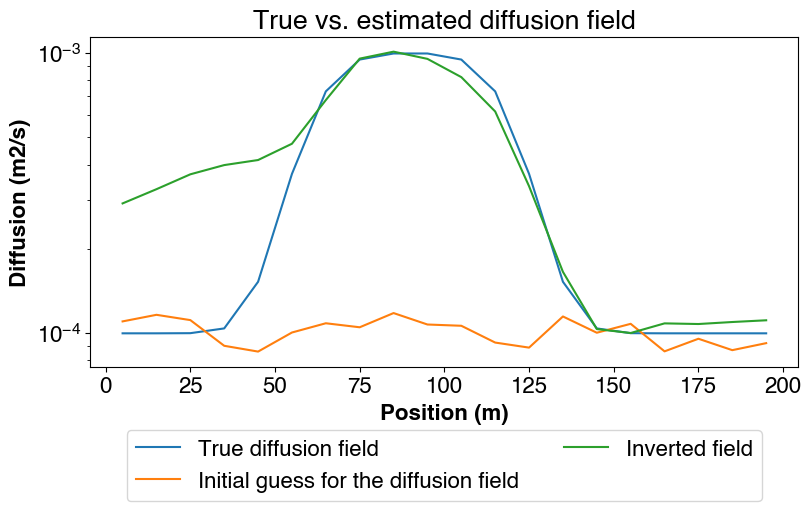

In [55]:
plotter = ngp.NestedGridPlotter(fig_params={"figsize": (8, 5)})
plotter.ax_dict["ax1-1"].plot(
    x_coordinates, diffusion_true, label="True diffusion field"
)
plotter.ax_dict["ax1-1"].plot(
    x_coordinates,
    diffusion_estimated,
    label="Initial guess for the diffusion field",
)
plotter.ax_dict["ax1-1"].plot(
    x_coordinates,
    param.values,
    label="Inverted field",
)
plotter.ax_dict["ax1-1"].set_xlabel("Position (m)", weight="bold")
plotter.ax_dict["ax1-1"].set_ylabel("Diffusion (m2/s)", weight="bold")
plotter.ax_dict["ax1-1"].set_yscale("log")
plotter.ax_dict["ax1-1"].legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plotter.ax_dict["ax1-1"].set_title("True vs. estimated diffusion field")
plotter.fig.set_facecolor("w")

fname = "true_vs_estimated_vs_inv_diffusion_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot the main results

NameError: name 'obj_funs' is not defined

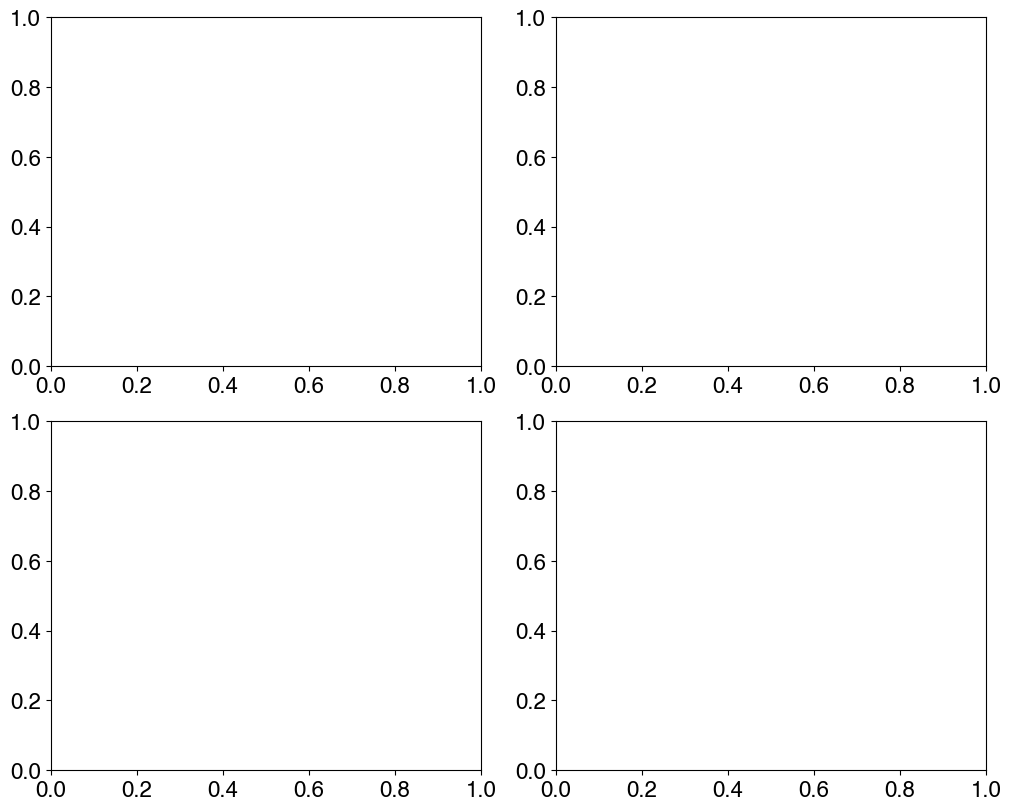

In [56]:
plotter = ngp.AnimatedPlotter(
    fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
)

# 1 frame per solver iteration
nb_frames: int = obj_funs.shape[0]

# 1) Gradient evolution
plotter.get_axis("ax1-1").plot(
    aligned_adjoint_gradients[:, 0, 0, 0], label="Initial", c="b"
)
plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")
# xlabel="Node #"

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "ADJ": {"y": aligned_adjoint_gradients[:, 0, 0, :], "kwargs": {"c": "g"}},
    },
    nb_frames=nb_frames,
)

plotter.ax_dict["ax1-1"].legend()


# 2) Parameter evolution
plotter.get_axis("ax1-2").plot(
    model_reference.tr_model.diffusion, c="b", label="Reference"
)
plotter.get_axis("ax1-2").plot(
    adjusted_diffusion[:, 0, 0, 0], c="orange", label="Initial"
)
plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "Inverted": {
            "y": adjusted_diffusion[:, 0, 0, :],
            "kwargs": {"c": "r", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
)
plotter.get_axis("ax1-2").set_title("Diffusivity field", fontweight="bold")
plotter.get_axis("ax1-2").set_xlabel("Node #")
plotter.get_axis("ax1-2").set_ylabel("[m2/s]")
plotter.ax_dict["ax1-2"].legend()
plotter.ax_dict["ax1-2"].set_yscale("log")

# 3) Objective function
vals = obj_funs
obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
for i in range(len(vals)):
    obj_fun_vals[: i + 1, i] = vals[: i + 1]

plotter.animated_multi_plot(
    ax_name="ax2-1",
    data={
        "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
    },
    nb_frames=nb_frames,
    title="Objective function",
    xlabel="Iteration #",
)
plotter.ax_dict["ax2-1"].set_yscale("log")

# 4) Observation vs predicted values
plot_observed_vs_simulated(
    plotter.ax_dict["ax2-2"],
    obs_vector=simu_inverse2.get_observation_vector() * 1000,
    pred_vector=simu_inverse2.get_results_matching_obs_vector(
        simu_inverse2.get_observables()
    )
    * 1000,
    pred_vector_initial=simu_estimate.get_results_matching_obs_vector(
        simu_inverse2.get_observables()
    )
    * 1000,
    units="$mmol.l^{-1}$",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("m_j_g_animation.html")
writer = HTMLWriter(fps=2, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

- Plot the concentrations

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        fwd_conc_true_hytec[node_id, 0, 0, :] + obs_noise[i],
        label="Reference HYTEC (noisy)",
        c="g",
        linestyle="none",
        marker=".",
        alpha=0.5,
    )
    ax.plot(fwd_conc_estimate_hytec[node_id, 0, 0, :], label="A priori HYTEC", c="r")
    ax.plot(
        fwd_conc_inversed_hytec[node_id, 0, 0, :], label="Post inversion HYTEC", c="b"
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentrations_after_inversion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)